In [ ]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/MEC_Stackelberg_Project'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
项目路径已设置为：/content/drive/MyDrive/MEC_Stackelberg_Project


In [5]:
import src.config as config
import src.models as models
import src.algorithms.user_game_solver as user_game_solver
import src.algorithms.Stackelberg_solver as Stackelberg_solver
import src.algorithms.baseline_solver as baseline_solver
import src.run_experiment as run_experiment
import src.utils as utils
import numpy as np
import matplotlib.pyplot as plt

SEED = 43

In [6]:
CONFIG_PATH = os.path.join(PROJECT_PATH, "configs", "base_10.json")
config = config.Config(CONFIG_PATH)

users = run_experiment.create_users(config,SEED,True)
provider = run_experiment.create_provider(config)
for user in users:
  print(user.user_id)
  user.print_bounds(1e-1,1e-1)
  user.print_costs(1e-1,1e-1)

0
 f_{thres}_ 0 = 1.8823904182590745  B_{thres}_ 0 = 3.827622483287052
 f_{hat}_ 0 = 8.824987894443755  B_{hat}_ 0 = 13.727542430103586
 C^l_ 0 = 7.0710620074382895  C_hat_e_ 0 = 4.510506064909468
 C_{hat}_ef_ 0 = 1.764997578888751  C_{hat}_eb_ 0 = 2.745508486020717
1
 f_{thres}_ 1 = 1.2443447401601482  B_{thres}_ 1 = 1.0217742693416199
 f_{hat}_ 1 = 13.633633803193309  B_{hat}_ 1 = 12.24851022965479
 C^l_ 1 = 17.511795247515767  C_hat_e_ 1 = 5.1764288065696205
 C_{hat}_ef_ 1 = 2.726726760638662  C_{hat}_eb_ 1 = 2.4497020459309584
2
 f_{thres}_ 2 = 0.7844614080490686  B_{thres}_ 2 = 0.335191702308002
 f_{hat}_ 2 = 12.024966257279342  B_{hat}_ 2 = 7.68281115547061
 C^l_ 2 = 20.048013744122855  C_hat_e_ 2 = 3.9415554825499903
 C_{hat}_ef_ 2 = 2.4049932514558683  C_{hat}_eb_ 2 = 1.536562231094122
3
 f_{thres}_ 3 = 2.1565794175577313  B_{thres}_ 3 = 5.364963179900877
 f_{hat}_ 3 = 9.646979600517012  B_{hat}_ 3 = 17.179199828017047
 C^l_ 3 = 7.966860219320041  C_hat_e_ 3 = 5.365235885706812

In [ ]:
"""
图2a: ESP/NSP 价格 vs. 总资源使用量
热力图
展示价格对用户资源购买量的影响
"""
pe_or, pn_or, X_or, U_or, results_or = baseline_solver.oracle_baseline_greedy(users, provider, (1e-3,20), (1e-3,20), 500)
print("pe_oracle, pn_oracle=", pe_or, pn_or)
print(f"X_oracle={X_or}, U_oracle={U_or}")
# 提取价格和收益
p_E_vals = np.array([r["p_E"] for r in results_or])
p_N_vals = np.array([r["p_N"] for r in results_or])
fb_util_vals = np.array([r["sum_f"]/provider.f_max+r["sum_b"]/provider.B_max for r in results_or])

plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_vals, p_N_vals, c=fb_util_vals, cmap="viridis", s=50)
plt.colorbar(sc, label="U_X")
plt.xlabel("p_E")
plt.ylabel("p_N")
plt.title("Resource Utilization over (p_E, p_N) Plane")
plt.show()

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive direc

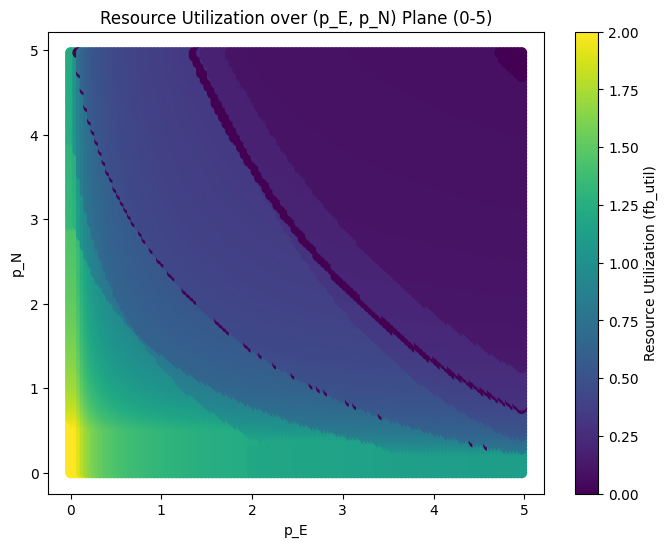

In [ ]:
# 筛选出 p_E 和 p_N 均在 [0,5] 区间内的结果
filtered_results = [r for r in results_or if 0 <= r["p_E"] <= 5 and 0 <= r["p_N"] <= 5]

# 提取筛选后的价格和收益
p_E_filtered = np.array([r["p_E"] for r in filtered_results])
p_N_filtered = np.array([r["p_N"] for r in filtered_results])
fb_util_filtered = np.array([r["sum_f"]/provider.f_max + r["sum_b"]/provider.B_max for r in filtered_results])

# 绘制散点图
plt.figure(figsize=(8,6))
sc = plt.scatter(p_E_filtered, p_N_filtered, c=fb_util_filtered, cmap="viridis", s=50)
plt.colorbar(sc, label="Resource Utilization (fb_util)")
plt.xlabel("p_E")
plt.ylabel("p_N")
plt.title("Resource Utilization over (p_E, p_N) Plane (0-5)")
plt.show()

Thresholds: fthres=1.5122, Bthres=1.5122


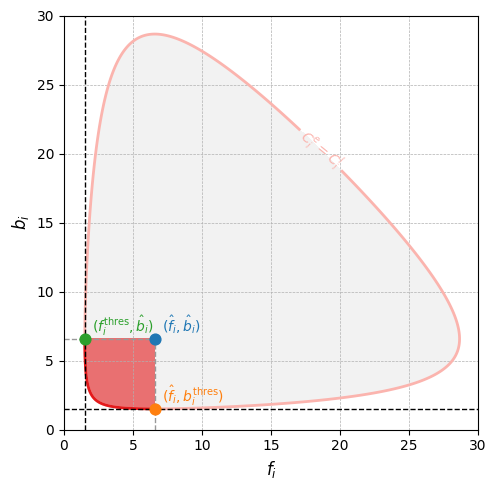

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
alpha_i = 13
d_i = 30
b_i = 30
S_i = 1
p_E = 9
p_N = 9
fl_i = 1
Cl_i = alpha_i * d_i / fl_i

# 计算最优点和阈值点
hatf = np.sqrt(alpha_i * d_i / p_E)
hatB = np.sqrt(alpha_i * b_i / (S_i * p_N))
hatCf = 2 * np.sqrt(alpha_i * d_i * p_E)
hatCB = 2 * np.sqrt(alpha_i * b_i * p_N / S_i)

fthres = ((Cl_i - hatCB) - np.sqrt((Cl_i - hatCB)**2 - hatCf**2)) / (2 * p_E)
Bthres = ((Cl_i - hatCf) - np.sqrt((Cl_i - hatCf)**2 - hatCB**2)) / (2 * p_N)
print(f"Thresholds: fthres={fthres:.4f}, Bthres={Bthres:.4f}")

# 创建函数
def cost_func(f, B):
    return alpha_i * d_i / f + alpha_i * b_i / (S_i * B) + p_E * f + p_N * B - Cl_i

# 网格数据
x = np.linspace(0.1, 30, 400)
y = np.linspace(0.1, 30, 400)
X, Y = np.meshgrid(x, y)
Z = cost_func(X, Y)

# 图示
fig, ax = plt.subplots(figsize=(6, 5))

# 等高线 (C^e_i = C^l_i)
contour = ax.contour(X, Y, Z, levels=[0], colors='#fbb4ae', linewidths=2)
ax.clabel(contour, inline=True, fontsize=10, fmt={0: r'$C^e_i = C^l_i$'})
ax.contourf(X, Y, Z, levels=[-1000, 0], colors=['grey'], alpha=0.1)

# 内部红色区域
ICx = np.linspace(fthres, hatf, 300)
ICy = np.linspace(Bthres, hatB, 300)
ICX, ICY = np.meshgrid(ICx, ICy)
ICZ = cost_func(ICX, ICY)
ax.contour(ICX, ICY, ICZ, levels=[0], colors='#e41a1c', linewidths=2)
ax.contourf(ICX, ICY, ICZ, levels=[-1000, 0], colors=['#e41a1c'], alpha=0.6)  # 内部扇形填充


# 标记关键点
points = {
    r'$(\hat{f}_i, \hat{b}_i)$': (hatf, hatB),
    r'$(\hat{f}_i, b_i^{\mathrm{thres}})$': (hatf, Bthres),
    r'$(f_i^{\mathrm{thres}}, \hat{b}_i)$': (fthres, hatB),
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色, 橙色, 绿色
for (label, (x_pt, y_pt)), c in zip(points.items(), colors):
    ax.scatter(x_pt, y_pt, color=c, s=60, zorder=5)
    ax.text(x_pt + 0.5, y_pt + 0.5, label, fontsize=10, color=c)

# 完整的切线（阈值线）
ax.axvline(x=fthres, color='black', linestyle='--', linewidth=1)
ax.axhline(y=Bthres, color='black', linestyle='--', linewidth=1)
ax.axvline(x=hatf, ymin=0, ymax=hatB/30, color='#999999', linestyle='--', linewidth=1)
ax.axhline(y=hatB, xmin=0, xmax=hatf/30, color='#999999', linestyle='--', linewidth=1)

# 坐标轴和标题修饰
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_xlabel('$f_i$', fontsize=12)
ax.set_ylabel('$b_i$', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
